In [1]:
import numpy as np
import xarray as xr
import pandas as pd
import copy
from datetime import datetime, timedelta
from keras.utils import to_categorical
# import visual keras
# import tensorflow as tf
from sklearn.metrics import balanced_accuracy_score
import optuna
from optuna.samplers import TPESampler
import keras
from keras.callbacks import ModelCheckpoint
from sklearn.utils.class_weight import compute_class_weight
import sys
import os
import joblib
import matplotlib.pyplot as plt

2023-09-09 14:54:21.512064: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
/glade/work/jhayron/conda-envs/cnn_wr/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
sys.path.append("/glade/u/home/jhayron/WR_Predictability/3_MLModels/")
from model_builders_v2 import *

## Helper functions

In [3]:
# def create_tf_datasets(input_data, output_data):
#     # Convert xarray dataset to numpy array for TensorFlow Dataset
#     input_images = input_data.transpose('time', 'lat', 'lon','channel').values
#     output_one_hot = output_data.values

#     # Create TensorFlow Datasets
#     input_dataset = tf.data.Dataset.from_tensor_slices(input_images)
#     output_dataset = tf.data.Dataset.from_tensor_slices(output_one_hot)

#     # Combine input and output datasets into a joint dataset
#     joint_dataset = tf.data.Dataset.zip((input_dataset, output_dataset))

#     return joint_dataset
def create_tf_datasets(input_data, output_data):
    # Convert xarray dataset to numpy array for TensorFlow Dataset
    input_images = input_data.transpose('time', 'lat', 'lon','channel').values
    output_one_hot = output_data.values

    # Create TensorFlow Datasets
    input_dataset = tf.data.Dataset.from_tensor_slices(input_images)
    output_dataset = tf.data.Dataset.from_tensor_slices(output_one_hot)

    # Combine input and output datasets into a joint dataset
    joint_dataset = tf.data.Dataset.zip((input_dataset, output_dataset))

    return (input_images,output_one_hot)

def create_datasets(input_anoms, var_name, df_shifts, week_out):
# Assuming you have the xarray.Dataset 'input_data' and the pandas.Series 'output_data'
    input_data = copy.deepcopy(input_anoms[var_name])

    array_temp = input_data.data
    array_temp[np.isfinite(array_temp)==False]=0
    input_data.data = array_temp

#     input_data = (input_data - input_data.mean('time')) / (input_data.std('time'))
    
#     input_data[np.isfinite(array_temp)==False] = 0
    
    # Reshape the data to add a new dimension
    values_reshaped = input_data.values.reshape(input_data.shape[0], input_data.shape[1], input_data.shape[2], 1)

    # Create a new xarray.DataArray with the reshaped data and the original coordinates
    input_data = xr.DataArray(values_reshaped, coords=input_data.coords, dims=('time', 'lat', 'lon', 'channel'))
    output_data = copy.deepcopy(df_shifts[f'week{week_out}']).dropna()

    # Step 1: Create a common date index that includes all dates in both the input and output data
    common_dates = np.intersect1d(input_data['time'].values, output_data.index)

    # Step 2: Reindex the input xarray dataset and the output DataFrame to the common date index
    input_data = input_data.sel(time=common_dates)
    output_data = output_data.loc[common_dates]

    # Step 3: One-hot encode the output DataFrame using to_categorical
    num_classes = len(output_data.unique())  # Number of classes (number of weeks in this case)
    output_data_encoded = to_categorical(output_data, num_classes=num_classes)
    output_data_encoded = pd.DataFrame(output_data_encoded,index=output_data.index)

    # Step 4: Create masks for training, validation, and testing periods
    train_mask = (output_data.index >= '1980-01-01') & (output_data.index <= '2010-12-31')
    val_mask = (output_data.index >= '2011-01-01') & (output_data.index <= '2015-12-31')
    test_mask = (output_data.index >= '2016-01-01') & (output_data.index <= '2020-12-31')

    # Step 5: Split the input xarray dataset and the output DataFrame into subsets
    input_train = input_data.sel(time=train_mask)
    input_val = input_data.sel(time=val_mask)
    input_test = input_data.sel(time=test_mask)

    output_train = output_data_encoded.loc[train_mask]
    output_val = output_data_encoded.loc[val_mask]
    output_test = output_data_encoded.loc[test_mask]

    train_joint_dataset = create_tf_datasets(input_train, output_train)
    val_joint_dataset = create_tf_datasets(input_val, output_val)
    test_joint_dataset = create_tf_datasets(input_test, output_test)

    # buffer_size = train_joint_dataset.cardinality()
    # train_joint_dataset = train_joint_dataset.shuffle(buffer_size)
    return train_joint_dataset, val_joint_dataset, test_joint_dataset

def get_output_from_dataset(dataset):
    output_array = []
    for input_data, output_data in dataset.as_numpy_iterator():
        output_array.append(output_data)

    # Convert the list of NumPy arrays into a single NumPy array
    output_array = np.array(output_array)
    return output_array

def balanced_accuracy(y_true, y_pred):
    y_true = tf.argmax(y_true, axis=1)
    y_pred = tf.argmax(y_pred, axis=1)
    return tf.py_function(balanced_accuracy_score, (y_true, y_pred), tf.float32)

def logging_callback(study, frozen_trial):
    previous_best_value = study.user_attrs.get("previous_best_value", None)
    if previous_best_value != study.best_value:
        study.set_user_attr("previous_best_value", study.best_value)
        print(
            "Trial {} finished with best value: {} and parameters: {}. ".format(
            frozen_trial.number,
            frozen_trial.value,
            frozen_trial.params,
            )
        )

In [4]:
def create_datasets_multichannel(input_data, df_shifts, week_out):
# Assuming you have the xarray.Dataset 'input_data' and the pandas.Series 'output_data'

    # Create a new xarray.DataArray with the reshaped data and the original coordinates
    output_data = copy.deepcopy(df_shifts[f'week{week_out}']).dropna()

    # Step 1: Create a common date index that includes all dates in both the input and output data
    common_dates = np.intersect1d(input_data['time'].values, output_data.index)

    # Step 2: Reindex the input xarray dataset and the output DataFrame to the common date index
    input_data = input_data.sel(time=common_dates)
    output_data = output_data.loc[common_dates]

    # Step 3: One-hot encode the output DataFrame using to_categorical
    num_classes = len(output_data.unique())  # Number of classes (number of weeks in this case)
    output_data_encoded = to_categorical(output_data, num_classes=num_classes)
    output_data_encoded = pd.DataFrame(output_data_encoded,index=output_data.index)

    # Step 4: Create masks for training, validation, and testing periods
    train_mask = (output_data.index >= '1980-01-01') & (output_data.index <= '2010-12-31')
    val_mask = (output_data.index >= '2011-01-01') & (output_data.index <= '2015-12-31')
    test_mask = (output_data.index >= '2016-01-01') & (output_data.index <= '2020-12-31')

    # Step 5: Split the input xarray dataset and the output DataFrame into subsets
    input_train = input_data.sel(time=train_mask)
    input_val = input_data.sel(time=val_mask)
    input_test = input_data.sel(time=test_mask)

    output_train = output_data_encoded.loc[train_mask]
    output_val = output_data_encoded.loc[val_mask]
    output_test = output_data_encoded.loc[test_mask]

    train_joint_dataset = create_tf_datasets(input_train, output_train)
    val_joint_dataset = create_tf_datasets(input_val, output_val)
    test_joint_dataset = create_tf_datasets(input_test, output_test)

    return train_joint_dataset, val_joint_dataset, test_joint_dataset

# Training

In [5]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

## GLOBAL SEED ##    
np.random.seed(42)
tf.random.set_seed(42)

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


2023-09-09 14:54:32.442307: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2023-09-09 14:54:32.443652: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2023-09-09 14:54:32.482580: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:61:00.0 name: Tesla V100-SXM2-32GB computeCapability: 7.0
coreClock: 1.53GHz coreCount: 80 deviceMemorySize: 31.75GiB deviceMemoryBandwidth: 836.37GiB/s
2023-09-09 14:54:32.482616: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2023-09-09 14:54:32.485262: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2023-09-09 14:54:32.485332: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublasLt.so.10
2

IC_SODA.nc   OHC100_SODA.nc  OHC50_SODA.nc   SD_ERA5.nc      SST_SODA.nc       STL_7cm_ERA5.nc   SWVL_28cm_ERA5.nc  U10_ERA5.nc
IT_SODA.nc   OHC200_SODA.nc  OHC700_SODA.nc  SSH_SODA.nc     STL_1m_ERA5.nc    STL_full_ERA5.nc  SWVL_7cm_ERA5.nc   U200_ERA5.nc
MLD_SODA.nc  OHC300_SODA.nc  OLR_ERA5.nc     SST_OISSTv2.nc  STL_28cm_ERA5.nc  SWVL_1m_ERA5.nc   SWVL_full_ERA5.nc  Z500_ERA5.ncm

In [6]:
names_vars = ['Z500_ERA5']

path_weekly_anoms = '/glade/scratch/jhayron/Data4Predictability/WeeklyAnoms_DetrendedStd/'
# path_weekly_anoms = '/glade/scratch/jhayron/Data4Predictability/WeeklyAnoms_Std_withTrends/'

list_input_anoms = []

var_names = []
for name_var in names_vars:
    list_input_anoms.append(xr.open_dataset(f'{path_weekly_anoms}{name_var}.nc'))
    var_names.append(list(list_input_anoms[-1].data_vars.keys())[0])
    
full_input_array = np.zeros((list_input_anoms[0][var_names[0]].values.shape[0],240,720,len(list_input_anoms)))

for ichannel in range(len(list_input_anoms)):
    full_input_array[:,:,:,ichannel] = list_input_anoms[ichannel][var_names[ichannel]].values
    
full_input_array[np.isfinite(full_input_array)==False]=0

# time = pd.to_datetime(list_input_anoms[0][var_names[0]].time.values)
# angles = (time.day_of_year - 1) / 365 * 2 * np.pi
# cyclical_series = np.sin(angles)

# array_cyclical = np.ones(full_input_array.shape)

# for i in range(array_cyclical.shape[1]):
#     for j in range(array_cyclical.shape[2]):
#         array_cyclical[:,i,j,0] = cyclical_series

# full_input_array = np.stack([full_input_array,array_cyclical],axis=-1)
# full_input_array = full_input_array[:,:,:,0,:]

da_input = xr.DataArray(
    data=full_input_array,
    dims=["time","lat", "lon","channel"],
    coords=dict(
        time=(["time"], list_input_anoms[0][var_names[0]].time.values),
        lat=(["lat"], list_input_anoms[0][var_names[0]].lat.values),
        lon=(["lon"], list_input_anoms[0][var_names[0]].lon.values),
        channel=(["channel"], np.arange(full_input_array.shape[-1])),
    )
)


In [7]:
del(full_input_array)
del(list_input_anoms)
del(var_names)
# del(array_cyclical)

In [8]:
# da_input = da_input.sel(lon=slice(180,330))

In [9]:
week_out=3
week_out_str = f'week{week_out}'

wr_series = pd.read_csv('/glade/work/jhayron/Data4Predictability/WR_Series_20230824.csv',\
                index_col=0,names=['week0'],skiprows=1,parse_dates=True)
for wk in range(2,10):
    series_temp = copy.deepcopy(wr_series["week0"])
    series_temp.index = series_temp.index - timedelta(weeks = wk-1)
    series_temp.name = f'week{wk-1}'
    if wk==2:
        df_shifts = pd.concat([pd.DataFrame(wr_series["week0"]),pd.DataFrame(series_temp)],axis=1)  
    else:
        df_shifts = pd.concat([df_shifts,pd.DataFrame(series_temp)],axis=1)
        
train_joint_dataset, val_joint_dataset, test_joint_dataset = \
    create_datasets_multichannel(da_input, df_shifts, week_out)
del(da_input)

2023-09-09 14:55:24.685270: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-09 14:55:24.685386: I tensorflow/compiler/jit/xla_gpu_device.cc:99] Not creating XLA devices, tf_xla_enable_xla_devices not set
2023-09-09 14:55:24.685954: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:61:00.0 name: Tesla V100-SXM2-32GB computeCapability: 7.0
coreClock: 1.53GHz coreCount: 80 deviceMemorySize: 31.75GiB deviceMemoryBandwidth: 836.37GiB/s
2023-09-09 14:55:24.686006: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2023-09-09 14:55:24.686036: I tensorflow/stream_executor/platfor

In [10]:
path_models = '/glade/work/jhayron/Data4Predictability/models/CNN_Aug29_2023/test_cycle/'

In [11]:
index_random = np.arange(len(train_joint_dataset[0]))
np.random.shuffle(index_random)

In [12]:
## Parameters

dict_params = {'model_base':'densenet',
               'type_pooling':'avg',
               'do':0.5,
               'md':8,
               'activation':'LeakyReLU',
               'weighted_loss':True,
               'bs':32,
               'lr':0.001,
               'input_shape':train_joint_dataset[0].shape[1:]}

# with strategy.scope():
model = build_predesigned_model(dict_params['model_base'],
                                dict_params['type_pooling'],
                                dict_params['do'],
                                dict_params['md'],
                                dict_params['activation'],
                                dict_params['input_shape'])

model.compile(loss=keras.losses.categorical_crossentropy, 
              optimizer=keras.optimizers.Adam(lr=dict_params['lr']),
              metrics=[balanced_accuracy,'accuracy'])  

epochs = 100
early_stopping_patience = 5

# Create the EarlyStopping callback
early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_balanced_accuracy',  # Metric to monitor
    patience=early_stopping_patience,  # Number of epochs with no improvement
    restore_best_weights=True  # Restore the weights of the best model
)

# Train the model with early stopping
try:
    os.mkdir(f'{path_models}{name_var}')
except: pass

filepath = f'{path_models}{name_var}/model_{week_out_str}_v0.h5'
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=0, save_best_only=True, 
                             mode='auto',save_weights_only=False)

if dict_params['weighted_loss']==True:

    y_train = copy.deepcopy(train_joint_dataset[1])
    y_train_integers = np.argmax(y_train, axis=1)
    class_weights = compute_class_weight(class_weight='balanced',classes=np.unique(y_train_integers),
                                         y = y_train_integers)
    d_class_weights = dict(enumerate(class_weights))

    history = model.fit(
        train_joint_dataset[0][index_random],
        train_joint_dataset[1][index_random],
        batch_size=dict_params['bs'],
        validation_data=val_joint_dataset,
        class_weight = d_class_weights,
        epochs=epochs,
        callbacks=[checkpoint,early_stopping_callback],
        verbose=1
    )
else:
    history = model.fit(
        train_joint_dataset[0][index_random],
        train_joint_dataset[1][index_random],
        batch_size=dict_params['bs'],
        validation_data=val_joint_dataset,
        epochs=epochs,
        callbacks=[checkpoint,early_stopping_callback],
        verbose=1
    )

2023-09-09 14:55:57.549280: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2023-09-09 14:55:57.549801: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2600000000 Hz


Epoch 1/100


2023-09-09 14:56:10.776248: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2023-09-09 14:56:10.996320: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.7


98/98 [==============================] - 81s 646ms/step - loss: 1.8382 - balanced_accuracy: 0.1950 - accuracy: 0.1753 - val_loss: 1.6270 - val_balanced_accuracy: 0.1829 - val_accuracy: 0.1609
Epoch 2/100
98/98 [==============================] - 57s 578ms/step - loss: 1.6063 - balanced_accuracy: 0.2133 - accuracy: 0.2340 - val_loss: 1.6340 - val_balanced_accuracy: 0.2137 - val_accuracy: 0.1379
Epoch 3/100
98/98 [==============================] - 57s 578ms/step - loss: 1.6259 - balanced_accuracy: 0.1901 - accuracy: 0.2199 - val_loss: 1.6068 - val_balanced_accuracy: 0.2046 - val_accuracy: 0.2126
Epoch 4/100
98/98 [==============================] - 57s 577ms/step - loss: 1.6212 - balanced_accuracy: 0.2004 - accuracy: 0.2154 - val_loss: 2.6637 - val_balanced_accuracy: 0.1839 - val_accuracy: 0.1935
Epoch 5/100
98/98 [==============================] - 57s 578ms/step - loss: 1.6326 - balanced_accuracy: 0.2076 - accuracy: 0.1895 - val_loss: 1.8250 - val_balanced_accuracy: 0.2152 - val_accuracy:

In [13]:
# with annual cycle - 0.21022729575634003
# without annual cycle - 0.20625002682209015

In [14]:
### test_loss, test_balanced_accuracy, test_accuracy = model.evaluate(test_joint_dataset.batch(len(test_joint_dataset)/5))
test_loss, test_balanced_accuracy, test_accuracy = model.evaluate(test_joint_dataset[0],test_joint_dataset[1])
# test_loss, test_balanced_accuracy, test_accuracy = model.evaluate(test_joint_dataset)
val_balanced_accuracy = np.max(history.history['val_balanced_accuracy'])
val_accuracy = np.max(history.history['val_accuracy'])

print('test_balanced_accuracy',test_balanced_accuracy)
print('test_accuracy',test_accuracy)
print('val_balanced_accuracy',val_balanced_accuracy)
print('val_accuracy',val_accuracy)



16/16 [==============================] - 2s 149ms/step - loss: 2.0682 - balanced_accuracy: 0.2063 - accuracy: 0.1265
test_balanced_accuracy 0.20625002682209015
test_accuracy 0.12648221850395203
val_balanced_accuracy 0.21572130918502808
val_accuracy 0.24137930572032928


In [29]:
# test_loss, test_balanced_accuracy, test_accuracy = model.evaluate(test_joint_dataset.batch(len(test_joint_dataset)/5))
test_loss, test_balanced_accuracy, test_accuracy = model.evaluate(test_joint_dataset[0],test_joint_dataset[1])
# test_loss, test_balanced_accuracy, test_accuracy = model.evaluate(test_joint_dataset)
val_balanced_accuracy = np.max(history.history['val_balanced_accuracy'])
val_accuracy = np.max(history.history['val_accuracy'])

print('test_balanced_accuracy',test_balanced_accuracy)
print('test_accuracy',test_accuracy)
print('val_balanced_accuracy',val_balanced_accuracy)
print('val_accuracy',val_accuracy)

16/16 [==============================] - 4s 83ms/step - loss: 1.2554 - balanced_accuracy: 0.6240 - accuracy: 0.7246
test_balanced_accuracy 0.624019205570221
test_accuracy 0.724609375
val_balanced_accuracy 0.7117378115653992
val_accuracy 0.7681992053985596


# evaluation

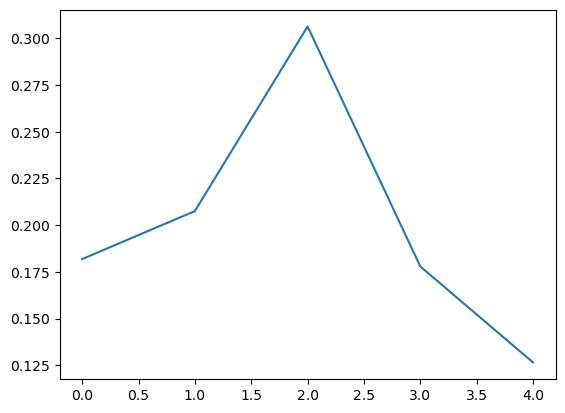

In [14]:
plt.plot(np.sum(test_joint_dataset[1],axis=0)/ np.sum(test_joint_dataset[1]))

In [15]:
predictions = model.predict(test_joint_dataset[0])

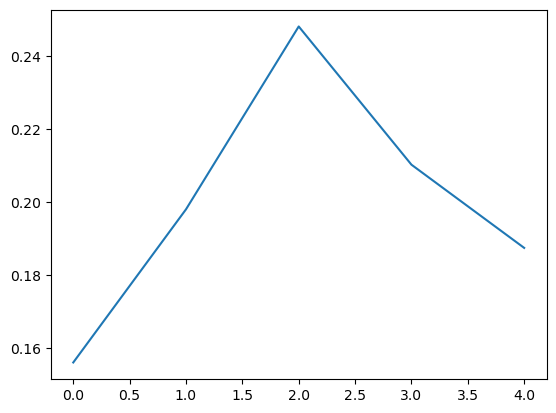

In [16]:
plt.plot(np.mean(predictions,axis=0))